## 01. 라이브러리 로드

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 한글 폰트 설정 (Windows: Malgun Gothic, macOS: AppleGothic)
try:
    plt.rc('font', family='Malgun Gothic')
except:
    plt.rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

## 02. 데이터 로드
- predict + CAGR + 베타 + 샤프지수 + 초과수익률 + 연간변동성 + 수익률 합쳐진 데이터셋

In [5]:
df = pd.read_excel('data/test_predict.xlsx')

## 03. 백테스팅 (run_backtest 함수 이용)
- 전년도 Factor들을 현재년도 데이터에 한번에 결합하여 분석용 df_year 생성
- vol_quartile : 변동성 분위 컬럼 생성
- 조건 정의
- 조건 이용하여 최종 종목 선정 (전년도 샤프지수 기준)
- 성과 검증
- 백테스팅 실행

In [8]:
def run_backtest(df):
    """
    주어진 데이터를 바탕으로 포트폴리오 백테스트를 실행합니다.
    """
    years = sorted(df['회계년도'].unique())
    all_portfolios = {}
    performance_records = []

    for year in years[1:]:
        all_portfolios[year] = {}
        
        df_pre_year = df[df['회계년도'] == year - 1].copy()
        df_current_year = df[df['회계년도'] == year].copy()

        # Factor들을 현재년도 데이터에 한번에 결합하여 분석용 df_year 생성
        pre_year_factors = df_pre_year[['회사명', '연간변동성', 'CAGR', '샤프지수']].rename(columns={
            '연간변동성': '전년도_연간변동성',
            'CAGR': '전년도_CAGR',
            '샤프지수': '전년도_샤프지수'
        })

        df_year = pd.merge(df_current_year, pre_year_factors, on='회사명', how='inner')

        # 'vol_quartile' (변동성 분위) 컬럼 생성
        try:
            df_year['vol_quartile'] = pd.qcut(df_year['전년도_연간변동성'], q=4, labels=[1, 2, 3, 4], duplicates='drop')
        except ValueError:
            print(f"--- {year}년: 데이터가 너무 적어 분위로 나눌 수 없어 건너뜁니다. ---")
            continue
            
        # 조건 딕셔너리 정의
        conditions = {
            'Class 0 (Q1)': (
                (df_year['target_pred'] == 0) &
                (df_year['vol_quartile'] == 1)
            ),
            'Class 1 (Q1~Q2)': (
                (df_year['target_pred'].isin([0, 1])) &
                (df_year['vol_quartile'].isin([2]))
            ),
            'Class 2 (Q1~Q3)': (
                (df_year['target_pred'].isin([1])) &
                (df_year['vol_quartile'].isin([3]))
            )
        }

        # 딕셔너리를 활용하여 각 전략별로 백테스트 실행
        for strategy_name, condition in conditions.items():
            # 정의된 조건으로 후보 종목 선정
            candidate_stocks_df = df_year[condition]
            
            if candidate_stocks_df.empty:
                continue

            # 최종 종목 선정 (전년도 샤프지수 기준)
            top_20_stocks = candidate_stocks_df.sort_values(by='전년도_샤프지수', ascending=False).head(20)
            portfolio_symbols = top_20_stocks['회사명'].tolist()
            
            all_portfolios[year][strategy_name] = portfolio_symbols
            
            portfolio_performance = df_current_year[df_current_year['회사명'].isin(portfolio_symbols)]
            
            if not portfolio_performance.empty:
                performance_records.append({
                    '성과측정연도': year,
                    '전략': strategy_name,
                    'CAGR': portfolio_performance['CAGR'].mean(),
                    '샤프지수': portfolio_performance['샤프지수'].mean(),
                    '베타': portfolio_performance['베타'].mean(),
                    '초과수익률': portfolio_performance['초과수익률'].mean(),
                    '수익률(%)': portfolio_performance['수익률(%)'].mean(),
                    '연간변동성': portfolio_performance['연간변동성'].mean(),
                })

    return all_portfolios, pd.DataFrame(performance_records)

portfolios, performance_df = run_backtest(df)

## 04. 수익률 계산
- 누적수익률
    - 기존 수익률(%) 소수점 형태로 변환
    - 전략별로 그룹화하여 누적수익률 계산
    - 계산에 사용한 수익률_decimal
- 초과누적수익률
    - 기존 초과수익률(%) 소수점 형태로 변환
    - 전략별로 그룹화하여 누적초과수익률 계산
    - 계산에 사용한 초과수익률_decimal

In [9]:
performance_df.sort_values(by=['전략', '성과측정연도'], inplace=True)

# 누적수익률 계산을 위해 기존 수익률(%)을 소수점 형태로 변환
performance_df['수익률_decimal'] = performance_df['수익률(%)'] / 100

# 각 '전략'별로 그룹화하여 누적수익률을 계산합니다.
performance_df['누적수익률(%)'] = performance_df.groupby('전략')['수익률_decimal'].transform(lambda x: (1 + x).cumprod() - 1) * 100

performance_df.drop(columns=['수익률_decimal'], inplace=True)

# 결과 확인
print("누적수익률이 추가된 최종 성과표")
display(performance_df)

누적수익률이 추가된 최종 성과표


,성과측정연도,전략,CAGR,샤프지수,베타,초과수익률,수익률(%),연간변동성,누적수익률(%)
0,2021,Class 0 (Q1),10.5550,0.460037,0.573763,30.775981,19.583481,0.343900,19.583481
3,2022,Class 0 (Q1),6.2395,-0.475456,0.335398,-14.624831,-8.252331,0.369967,9.715057
6,2023,Class 0 (Q1),1.7800,-0.273665,0.361703,1.407042,-1.635958,0.352201,7.920165
1,2021,Class 1 (Q1~Q2),16.9895,-0.162910,0.737509,11.674159,0.391659,0.426303,0.391659
4,2022,Class 1 (Q1~Q2),13.1290,-0.516200,0.775606,-12.791645,-7.251645,0.424249,-6.888388
7,2023,Class 1 (Q1~Q2),3.8475,-0.233227,0.616607,9.705326,6.409826,0.517750,-0.920095
2,2021,Class 2 (Q1~Q3),8.2110,-0.128887,0.933606,13.950889,2.510889,0.469078,2.510889
5,2022,Class 2 (Q1~Q3),4.2065,-0.802204,0.952199,-33.177206,-27.637206,0.474276,-25.820257
8,2023,Class 2 (Q1~Q3),10.4600,0.301452,0.819651,82.917454,79.470454,0.552408,33.130722


In [10]:
performance_df.sort_values(by=['전략', '성과측정연도'], inplace=True)

# 초과누적수익률 계산을 위해 기존 수익률(%)을 소수점 형태로 변환
performance_df['초과수익률_decimal'] = performance_df['초과수익률'] / 100

# 각 '전략'별로 그룹화하여 초과누적수익률을 계산
performance_df['초과누적수익률(%)'] = performance_df.groupby('전략')['초과수익률_decimal'].transform(lambda x: (1 + x).cumprod() - 1) * 100

performance_df.drop(columns=['초과수익률_decimal'], inplace=True)

print("누적수익률이 추가된 최종 성과표")
display(performance_df)

누적수익률이 추가된 최종 성과표


,성과측정연도,전략,CAGR,샤프지수,베타,초과수익률,수익률(%),연간변동성,누적수익률(%),초과누적수익률(%)
0,2021,Class 0 (Q1),10.5550,0.460037,0.573763,30.775981,19.583481,0.343900,19.583481,30.775981
3,2022,Class 0 (Q1),6.2395,-0.475456,0.335398,-14.624831,-8.252331,0.369967,9.715057,11.650215
6,2023,Class 0 (Q1),1.7800,-0.273665,0.361703,1.407042,-1.635958,0.352201,7.920165,13.221181
1,2021,Class 1 (Q1~Q2),16.9895,-0.162910,0.737509,11.674159,0.391659,0.426303,0.391659,11.674159
4,2022,Class 1 (Q1~Q2),13.1290,-0.516200,0.775606,-12.791645,-7.251645,0.424249,-6.888388,-2.610803
7,2023,Class 1 (Q1~Q2),3.8475,-0.233227,0.616607,9.705326,6.409826,0.517750,-0.920095,6.841136
2,2021,Class 2 (Q1~Q3),8.2110,-0.128887,0.933606,13.950889,2.510889,0.469078,2.510889,13.950889
5,2022,Class 2 (Q1~Q3),4.2065,-0.802204,0.952199,-33.177206,-27.637206,0.474276,-25.820257,-23.854833
8,2023,Class 2 (Q1~Q3),10.4600,0.301452,0.819651,82.917454,79.470454,0.552408,33.130722,39.282801


## 05. 연도 별 전략별 후보 종목 리스트 출력

In [11]:
for year, strategies in portfolios.items():
    print(f"--- 포트폴리오 구성 연도: {year} ---")
    for strategy, stocks in strategies.items():
        print(f"전략: {strategy}")
        # 종목 코드를 쉼표로 구분된 문자열로 변환
        stock_list_str = ', '.join(map(str, stocks))
        print(f"  - 선정 종목 ({len(stocks)}개): {stock_list_str}")
    print("\n")

--- 포트폴리오 구성 연도: 2021 ---
전략: Class 0 (Q1)
  - 선정 종목 (20개): 대성홀딩스(주), 동일산업(주), 미원상사(주), (주)선광, 한국철강(주), (주)카카오, (주)세아제강지주, KISCO홀딩스(주), (주)국순당, (주)휴스틸, (주)비와이씨, 미원스페셜티케미칼(주), (주)유니드, 국도화학(주), (주)골프존홀딩스, (주)동원개발, 포스코홀딩스(주), (주)부-스타, 대창단조(주), (주)케이씨
전략: Class 1 (Q1~Q2)
  - 선정 종목 (20개): (주)파크시스템스, (주)한컴위드, (주)엘엑스세미콘, 에이치엔에스하이텍(주), 대한제강(주), (주)한솔케미칼, (주)포스코퓨처엠, 아이에스동서(주), 경남스틸(주), 자이에스앤디(주), 디와이피엔에프(주), 에이치디현대미포(주), 미원홀딩스(주), (주)아바텍, (주)제이에스코퍼레이션, (주)잉크테크, (주)세아제강, 에스케이씨(주), 삼현철강(주), (주)유진테크
전략: Class 2 (Q1~Q3)
  - 선정 종목 (20개): (주)아티스트스튜디오, 이구산업(주), 코스모신소재(주), 큐렉소(주), (주)코렌텍, (주)티엘아이, (주)레드캡투어, (주)동운아나텍, (주)블루콤, 경인전자(주), (주)다우데이타, (주)서진시스템, (주)오리콤, (주)포니링크, 엘에스마린솔루션(주), 아남전자(주), (주)모헨즈, (주)케이프, (주)쇼박스, (주)오텍


--- 포트폴리오 구성 연도: 2022 ---
전략: Class 0 (Q1)
  - 선정 종목 (20개): (주)선광, 대성홀딩스(주), 동일산업(주), (주)삼천리, 고려신용정보(주), (주)케이티, (주)태웅, 엘케이삼양(주), (주)인터로조, (주)엠에스씨, 한국항공우주산업(주), (주)빅솔론, (주)파마리서치, 고려아연(주), (주)에스피씨삼립, (주)정상제이엘에스, 미원스페셜티케미칼(주), (주)신영와코루, (주)경방, (주)진양홀딩스
전략: Class 1 (Q1~Q2)
  - 선정 종목 (20

## 06. 결과 출력 및 시각화

In [13]:
print("전략별 연간 성과")

if not performance_df.empty:
    # 더 명확한 비교를 위해 '전략'을 컬럼으로 피벗팅
    performance_pivot = performance_df.pivot(index='성과측정연도', columns='전략')
    print(performance_pivot.round(4))
else:
    print("성과 기록이 없습니다.")

전략별 연간 성과
               CAGR                                         샤프지수  \
전략     Class 0 (Q1) Class 1 (Q1~Q2) Class 2 (Q1~Q3) Class 0 (Q1)   
성과측정연도                                                             
2021        10.5550         16.9895          8.2110       0.4600   
2022         6.2395         13.1290          4.2065      -0.4755   
2023         1.7800          3.8475         10.4600      -0.2737   

                                                 베타                  \
전략     Class 1 (Q1~Q2) Class 2 (Q1~Q3) Class 0 (Q1) Class 1 (Q1~Q2)   
성과측정연도                                                                
2021           -0.1629         -0.1289       0.5738          0.7375   
2022           -0.5162         -0.8022       0.3354          0.7756   
2023           -0.2332          0.3015       0.3617          0.6166   

                              초과수익률  ...          수익률(%)        연간변동성  \
전략     Class 2 (Q1~Q3) Class 0 (Q1)  ... Class 2 (Q1~Q3) Class 0 (Q1)   
성과측정연도  

#### 성과 시각화 - 선그래프

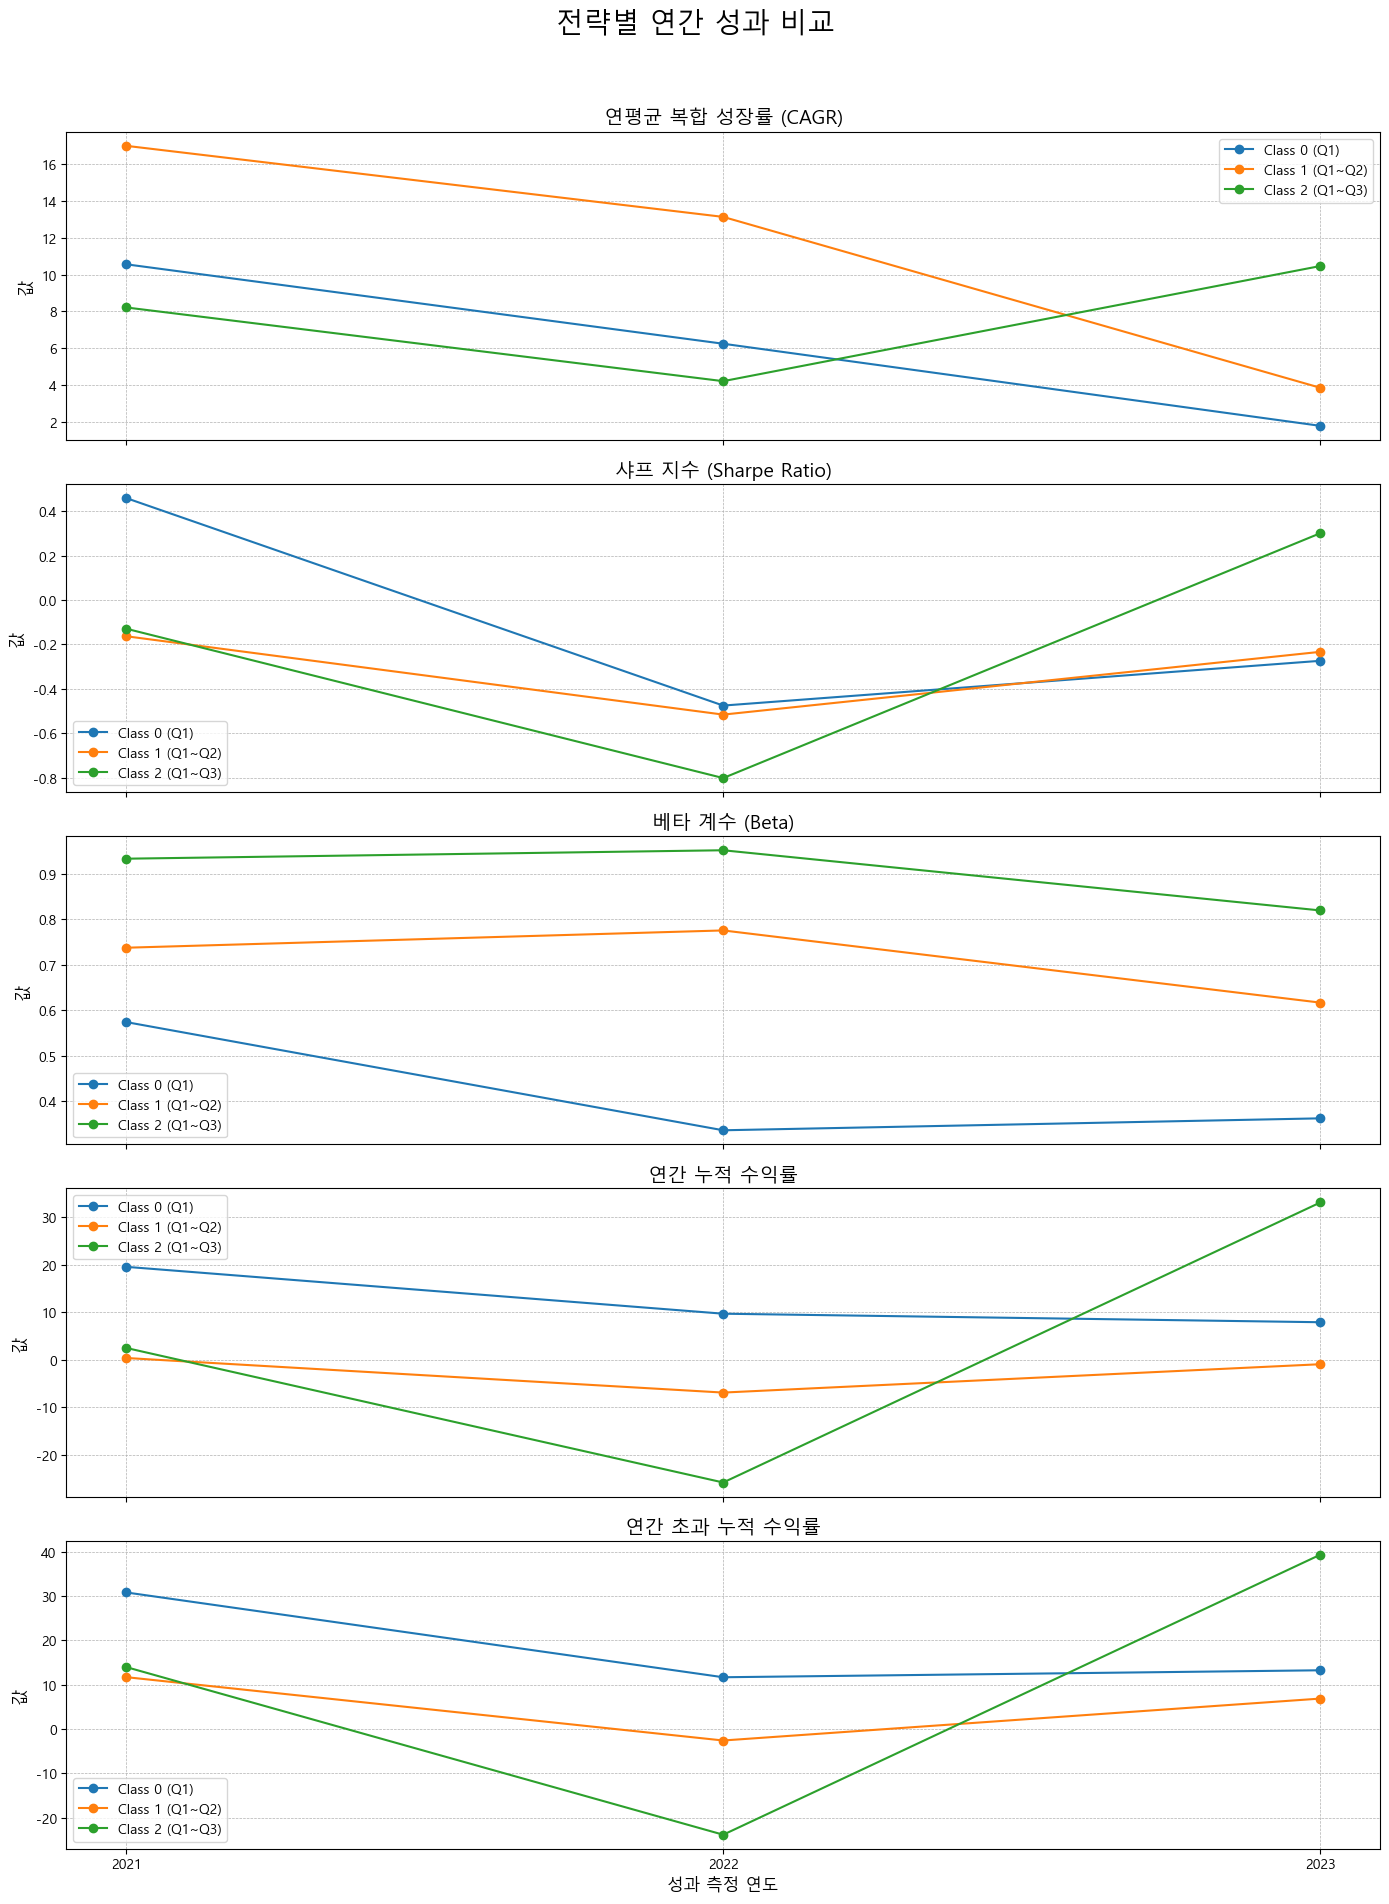

In [14]:
metrics_to_plot = {
    'CAGR': '연평균 복합 성장률 (CAGR)',
    '샤프지수': '샤프 지수 (Sharpe Ratio)',
    '베타': '베타 계수 (Beta)',
    '누적수익률(%)' : '연간 누적 수익률',
    '초과누적수익률(%)' : '연간 초과 누적 수익률'
}

# 모든 전략 이름 가져오기
strategies = sorted(performance_df['전략'].unique())

# 각 성과 지표에 대한 그래프 생성
fig, axes = plt.subplots(nrows=len(metrics_to_plot), ncols=1, figsize=(14, 20), sharex=True)
fig.suptitle('전략별 연간 성과 비교', fontsize=20, y=0.95)

# 각 지표를 반복하며 그래프 그리기
for i, (metric, title) in enumerate(metrics_to_plot.items()):
    ax = axes[i]
    # 각 전략의 성과를 선 그래프로 그리기
    for strategy in strategies:
        strategy_data = performance_df[performance_df['전략'] == strategy]
        ax.plot(strategy_data['성과측정연도'], strategy_data[metric], marker='o', linestyle='-', label=strategy)
    
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('값', fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.xlabel('성과 측정 연도', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

#### 성과 시각화 - 막대그래프

C:\Users\tmddn\AppData\Local\Temp\ipykernel_19424\1069949648.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='전략', y=metric, data=final_performance, ax=axes[ax_index], palette='viridis')
C:\Users\tmddn\AppData\Local\Temp\ipykernel_19424\1069949648.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='전략', y=metric, data=final_performance, ax=axes[ax_index], palette='viridis')


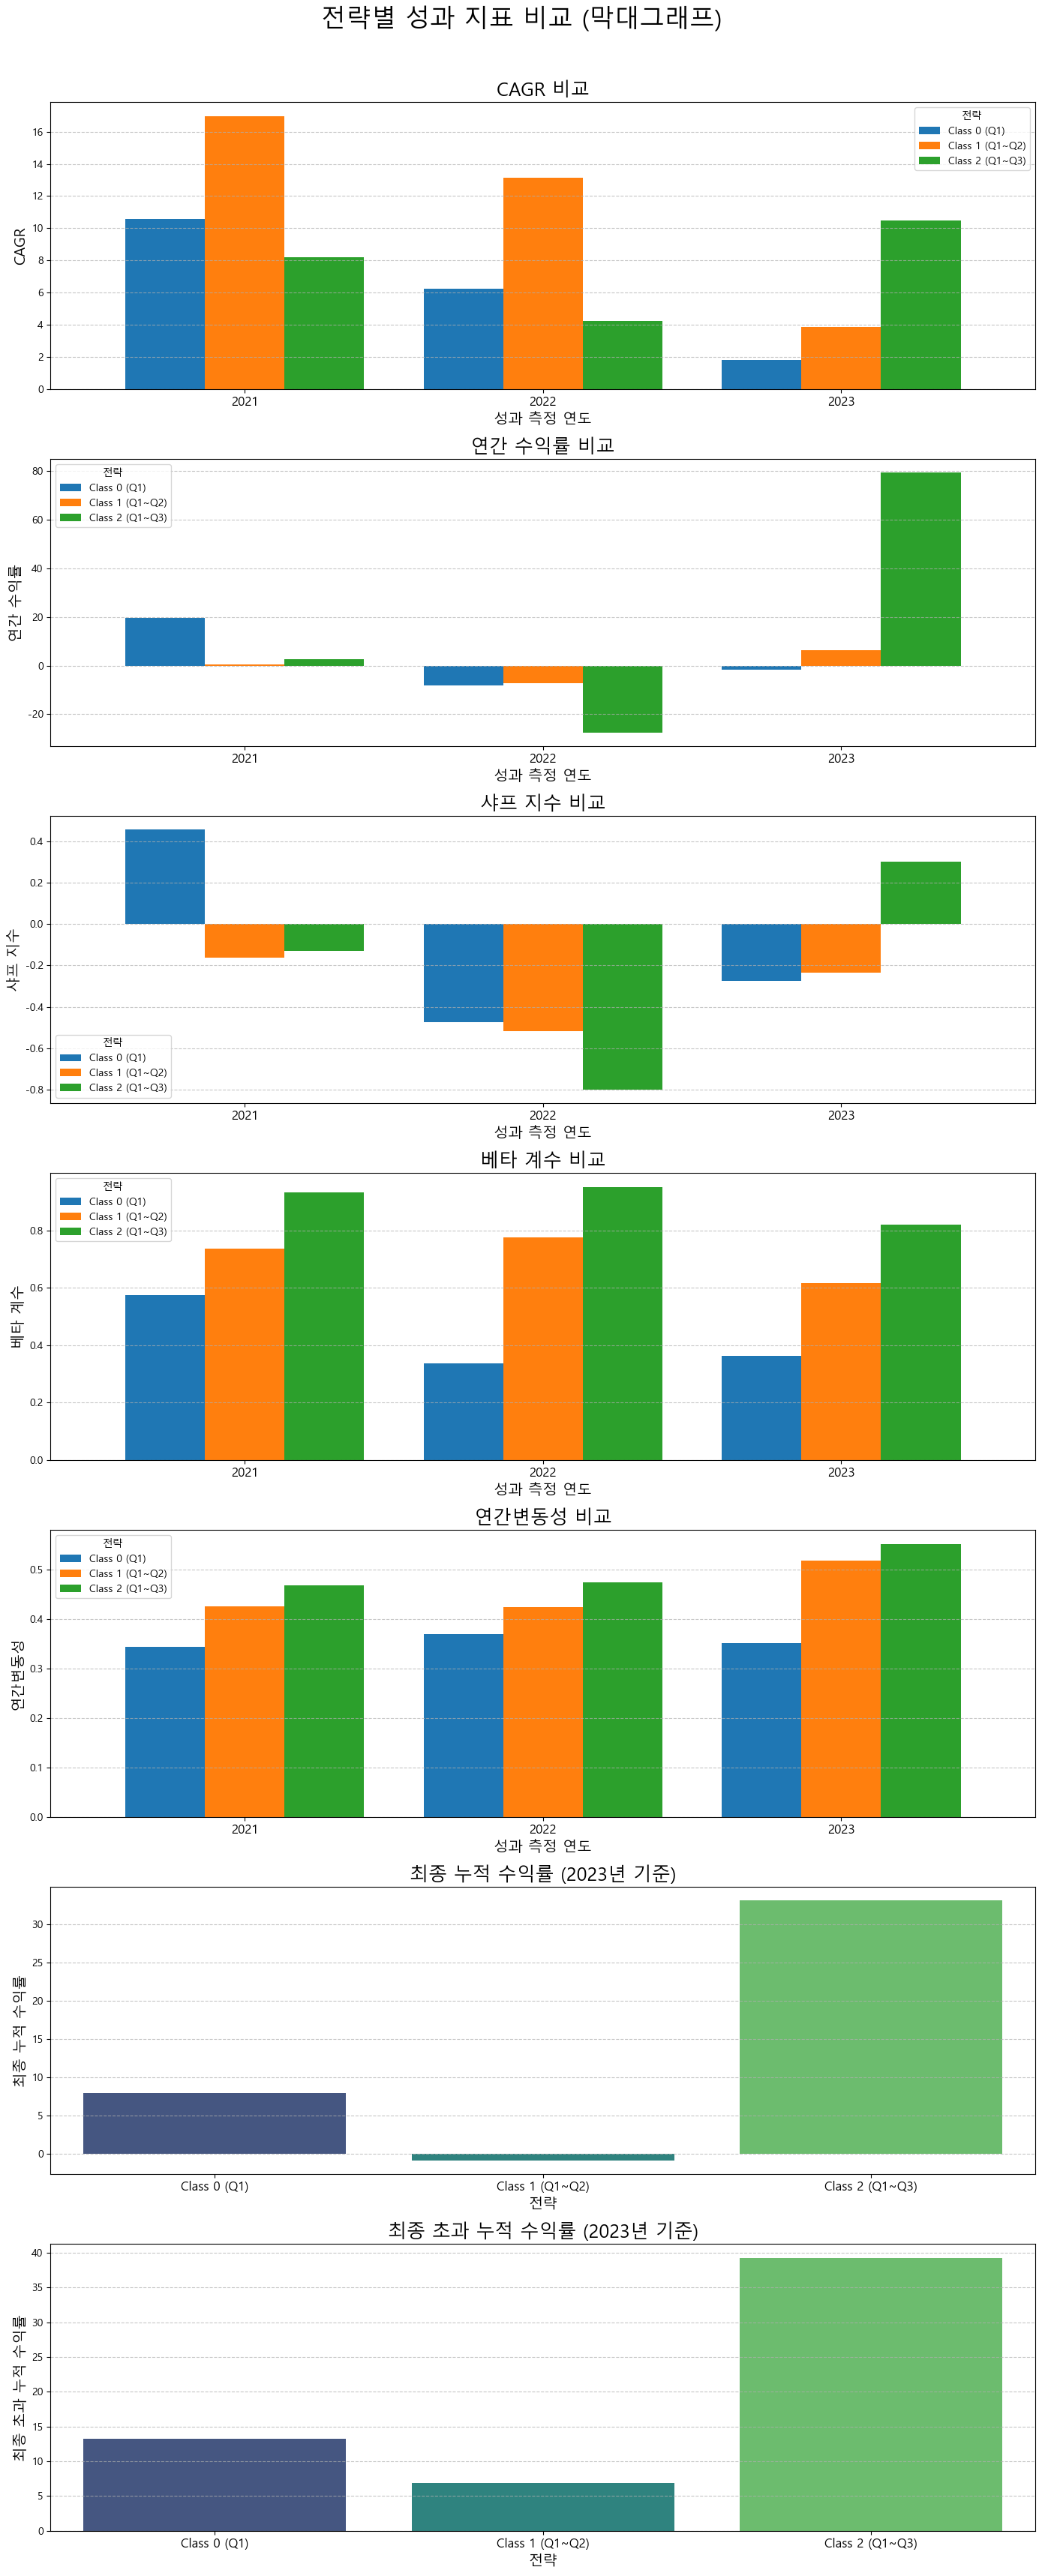

In [15]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(14, 35))
fig.suptitle('전략별 성과 지표 비교 (막대그래프)', fontsize=24, y=0.98)

annual_metrics = {
    'CAGR': 'CAGR',
    '수익률(%)': '연간 수익률',
    '샤프지수': '샤프 지수',
    '베타': '베타 계수',
    '연간변동성': '연간변동성',
}

for i, (metric, title) in enumerate(annual_metrics.items()):
    # 데이터를 시각화하기 좋은 형태로 피벗(pivot)
    pivot_df = performance_df.pivot(index='성과측정연도', columns='전략', values=metric)
    
    # 묶은 막대그래프 그리기
    pivot_df.plot(kind='bar', ax=axes[i], width=0.8)
    
    axes[i].set_title(f'{title} 비교', fontsize=18)
    axes[i].set_ylabel(title, fontsize=14)
    axes[i].set_xlabel('성과 측정 연도', fontsize=14)
    axes[i].tick_params(axis='x', rotation=0, labelsize=12)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    axes[i].legend(title='전략')


# 최종 누적 지표 시각화 (단일 막대그래프)
final_year = performance_df['성과측정연도'].max()
final_performance = performance_df[performance_df['성과측정연도'] == final_year]

cumulative_metrics = {
    '누적수익률(%)': '최종 누적 수익률',
    '초과누적수익률(%)': '최종 초과 누적 수익률'
}

for i, (metric, title) in enumerate(cumulative_metrics.items()):
    ax_index = i + 5
    
    sns.barplot(x='전략', y=metric, data=final_performance, ax=axes[ax_index], palette='viridis')
    
    axes[ax_index].set_title(f'{title} ({final_year}년 기준)', fontsize=18)
    axes[ax_index].set_ylabel(title, fontsize=14)
    axes[ax_index].set_xlabel('전략', fontsize=14)
    axes[ax_index].tick_params(axis='x', rotation=0, labelsize=12)
    axes[ax_index].grid(axis='y', linestyle='--', alpha=0.7)
    
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## 07. 코스피, 코스닥 벤치마크 수익률과 비교
- 코스피_코스닥 수익률 데이터 불러오기
- 컬럼명 재정의
- 연도 지정

In [17]:
market_df = pd.read_excel('data/krx/코스피_코스닥_수익률_4월.xlsx')
market_df.rename(columns={'KOSPI 수익률 (%)': 'KOSPI', 'KOSDAQ 수익률 (%)': 'KOSDAQ'}, inplace=True)
market_df = market_df[market_df['연도'] > 2020]

#### 코스피/코스닥 연간 및 누적 수익률 계산
- 연도별로 그룹화하여 연간 수익률 계산 : (1 + 일별/월별 수익률)을 연 단위로 누적 곱한 후 1을 빼서 계산
- 연간 누적 수익률 계산
- 백테스트 시작 전 시점의 누적수익률을 0으로 설정 (그래프용)
- % 단위로 변환

In [22]:
market_df[['KOSPI', 'KOSDAQ']] = market_df[['KOSPI', 'KOSDAQ']] / 100

# (1 + 일별/월별 수익률)을 연 단위로 누적 곱한 후 1을 빼서 계산
annual_market_returns = market_df.groupby('연도')[['KOSPI', 'KOSDAQ']].apply(lambda x: (1 + x).prod() - 1)

annual_market_returns['KOSPI_누적'] = (1 + annual_market_returns['KOSPI']).cumprod() - 1
annual_market_returns['KOSDAQ_누적'] = (1 + annual_market_returns['KOSDAQ']).cumprod() - 1

# 백테스트 시작 전 시점(2019년)의 누적수익률을 0으로 설정 (그래프용)
start_row = pd.DataFrame([{'KOSPI_누적': 0, 'KOSDAQ_누적': 0}], index=[2019])
annual_market_returns = pd.concat([start_row, annual_market_returns]).sort_index()

annual_market_returns *= 100

#### 시각화
- 비교 위해 2019 데이터 추가
- 2020년 이후 데이터만 필터링
- 그래프 생성
- x축에 표시할 위치와 라벨 정의
- 그래프 1 : 연간 누적 수익률 비교
- 그래프 2 : 연간 초과 누적 수익률 비교

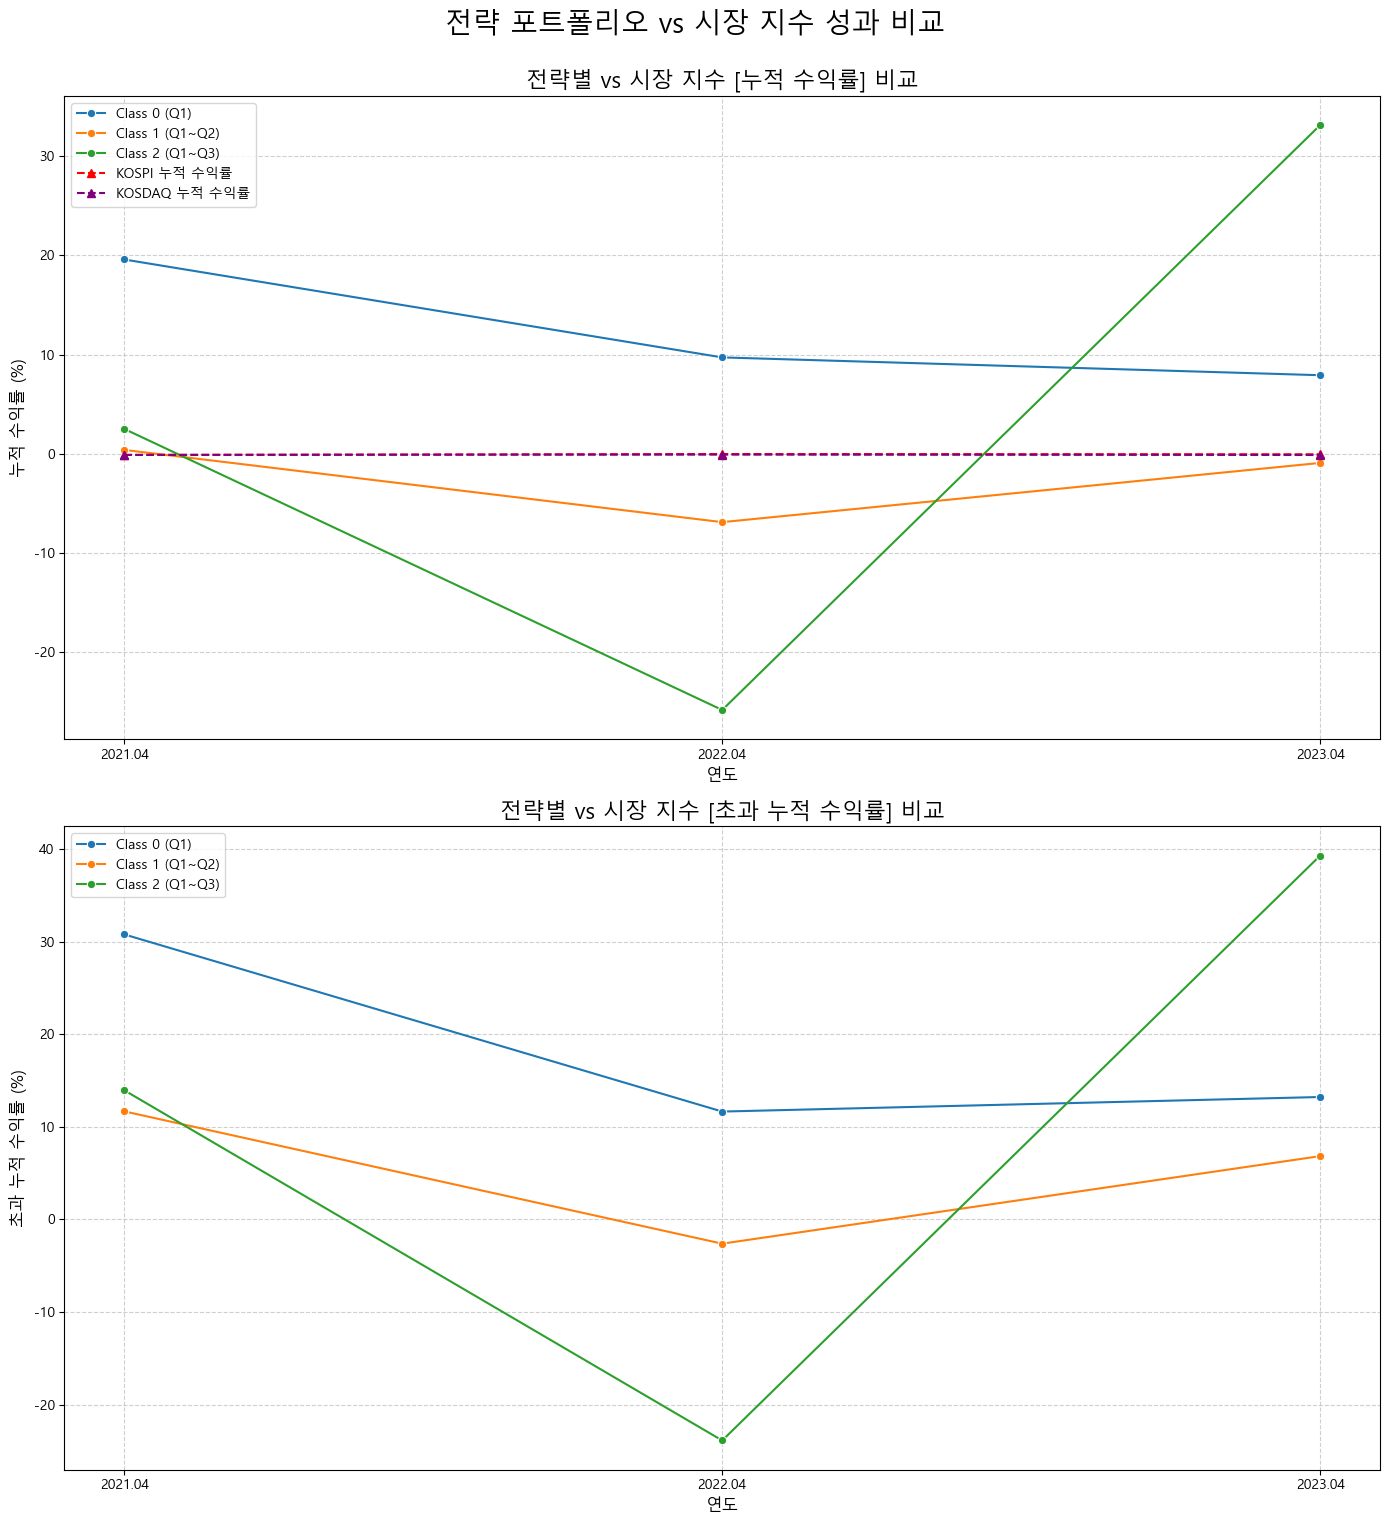

In [24]:
# 비교를 위해 백테스트 시작 전(2019) 데이터 추가
strategies = sorted(performance_df['전략'].unique())
start_data = []
for strategy in strategies:
    start_data.append({'성과측정연도': 2020, '전략': strategy, '누적수익률(%)': 0, '초과누적수익률(%)': 0})
performance_df_plot = pd.concat([pd.DataFrame(start_data), performance_df], ignore_index=True)


# 주요 수정 사항 1: 2020년 이후 데이터만 필터링
plot_data_strategy = performance_df_plot[performance_df_plot['성과측정연도'] >= 2021]
plot_data_market = annual_market_returns[annual_market_returns.index >= 2021]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 16))
fig.suptitle('전략 포트폴리오 vs 시장 지수 성과 비교', fontsize=20, y=0.95)

# 주요 수정 사항 2: x축에 표시할 위치와 라벨 정의
tick_locations = [2021, 2022, 2023]
tick_labels = ['2021.04', '2022.04', '2023.04']


# 그래프 1: 연간 누적 수익률 비교
ax1 = axes[0]
sns.lineplot(data=plot_data_strategy, x='성과측정연도', y='누적수익률(%)', hue='전략', marker='o', ax=ax1)
ax1.plot(plot_data_market.index, plot_data_market['KOSPI_누적'], marker='^', linestyle='--', color='red', label='KOSPI 누적 수익률')
ax1.plot(plot_data_market.index, plot_data_market['KOSDAQ_누적'], marker='^', linestyle='--', color='purple', label='KOSDAQ 누적 수익률')
ax1.set_title('전략별 vs 시장 지수 [누적 수익률] 비교', fontsize=16)
ax1.set_ylabel('누적 수익률 (%)', fontsize=12)
ax1.set_xlabel('연도', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()
ax1.set_xticks(tick_locations)
ax1.set_xticklabels(tick_labels)


# 그래프 2: 연간 초과 누적 수익률 비교
ax2 = axes[1]
sns.lineplot(data=plot_data_strategy, x='성과측정연도', y='초과누적수익률(%)', hue='전략', marker='o', ax=ax2)
# ax2.plot(plot_data_market.index, plot_data_market['KOSPI_초과누적'], marker='^', linestyle='--', color='red', label='KOSPI (초과)')
# ax2.plot(plot_data_market.index, plot_data_market['KOSDAQ_초과누적'], marker='^', linestyle='--', color='purple', label='KOSDAQ (초과)')
ax2.set_title('전략별 vs 시장 지수 [초과 누적 수익률] 비교', fontsize=16)
ax2.set_ylabel('초과 누적 수익률 (%)', fontsize=12)
ax2.set_xlabel('연도', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()
ax2.set_xticks(tick_locations)
ax2.set_xticklabels(tick_labels)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()